In [306]:


import _init_paths
from PIL import Image
import numpy as np
import cv2
import random
import copy

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown
from vcl.models.vqvae import *
from vcl.models.trackers import *
from vcl.utils import *
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

import matplotlib.pyplot as plt
%matplotlib inline


target_image_size = 256

output_dir = '/home/lr/project/vcl_output/vis_correspondence'

if os.path.exists(output_dir): os.makedirs(output_dir, exist_ok=True)

samples = []
with open('/home/lr/dataset/YouTube-VOS/2018/train/test_records.txt', 'r') as f:
    for line in f.readlines():
        name, frame_idx, pixel_idx = line.strip('\n').split()
        samples.append([name, int(frame_idx), int(pixel_idx)])
        
visualizer = Correspondence_Visualizer(mode='pair', radius=6)


def main(x1, x2, model):
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    plt = visualizer.visualize([frame1, frame2], [enc1, enc2], sample_idx)
    # visualize_correspondence_quant(enc1, enc2, sample_idx, frame1, frame2, scale=32)
    return plt
    

In [307]:
## sample frame
import os.path as osp
import glob


# sample_video_idx = 92
sample_video_idx = random.randint(0, 300)
sample = {}
sample['frames_path'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx][0], '*.jpg')))


frame_idx = samples[sample_video_idx][1]
sample_idx = samples[sample_video_idx][2]
video_name = sample['frames_path'][0].split('/')[-2]


frame1 = cv2.imread(sample['frames_path'][frame_idx])[:,:,::-1]

frame2 = cv2.imread(sample['frames_path'][min(frame_idx+1, len(sample['frames_path'])-1)])[:,:,::-1]
frame1 = cv2.resize(frame1, (256,256))
frame2 = cv2.resize(frame2, (256,256))

print('sample frames from {}'.format(sample['frames_path'][0]))

x1_rgb = preprocess_(frame1, mode='rgb')
x2_rgb = preprocess_(frame2, mode='rgb')

x1_lab = preprocess_(frame1, mode='lab')
x2_lab = preprocess_(frame2, mode='lab')

sample frames from /home/lr/dataset/YouTube-VOS/2018/train/JPEGImages/0e0930474b/00000.jpg


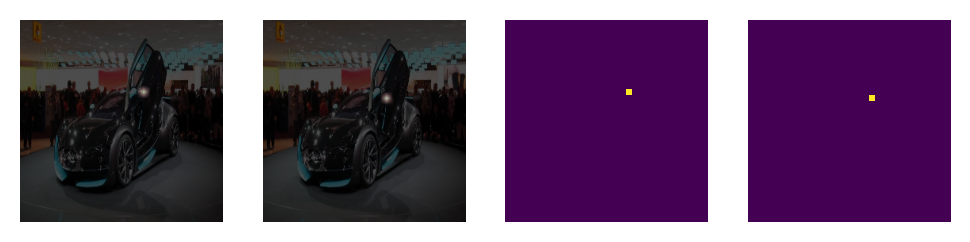

In [308]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, )),
    test_cfg=dict(),
    train_cfg=dict()
    )

params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_mast_12_2/epoch_1600.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)
model_name = 'mast'

model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model)
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))

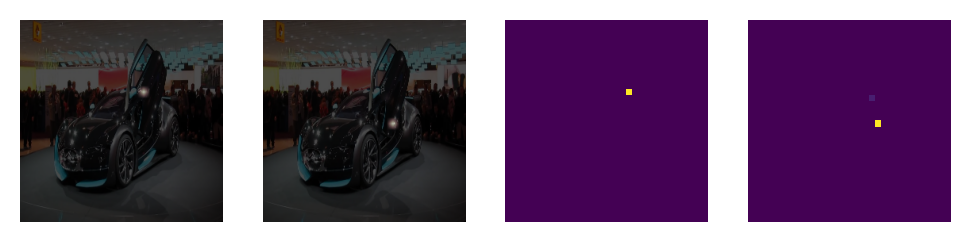

In [309]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_mast_14/epoch_1600.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)
model_name = 'mast_vq'


model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model)
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))

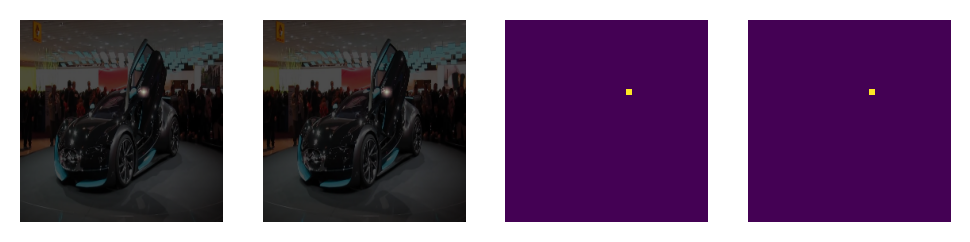

In [310]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_38/epoch_3200.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)
model_name = 'vq'


model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model)
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))

2022-04-01 12:56:55,800 - vcl - INFO - Loading /home/lr/models/ssl/image_based/detco_200ep_AA.pth as torchvision


Use load_from_local loader


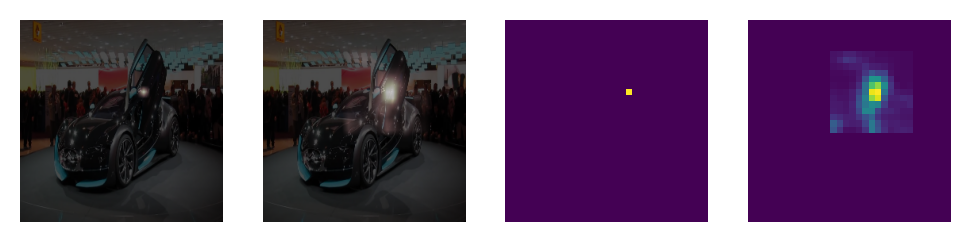

In [311]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=50, strides=(1, 2, 1, 1), out_indices=(3, ), pretrained='/home/lr/models/ssl/image_based/detco_200ep_AA.pth'),
    test_cfg=dict(),
    train_cfg=dict()
    )

model_name = 'decto'

# params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_38/epoch_3200.pth')
# state_dict = params['state_dict']
# state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
# model.load_state_dict(state_dict, strict=False)

# sample_idx = random.randint(0,255)
model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model)
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))

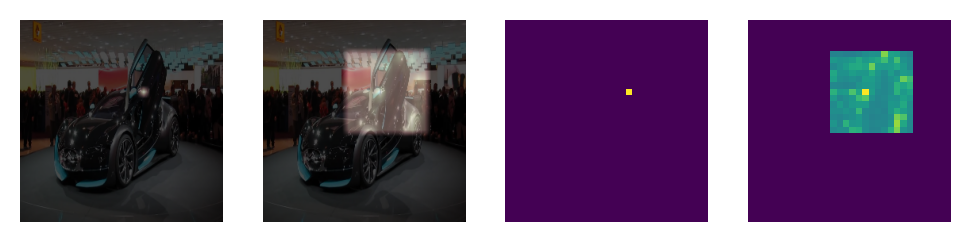

In [312]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, )),
    test_cfg=dict(),
    train_cfg=dict()
    )

params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/train_vqvae_video_d2_nemd2048_contrastive_byol_commit1.0_v2/epoch_3200.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)
model_name = 'vfs_vq'



model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model)
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))

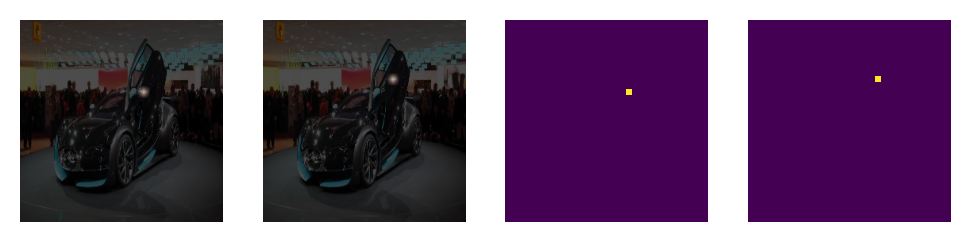

In [313]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/dist_nl_l2_layer4_mast_36/epoch_1600.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)
model_name = 'mast_vfs_distillation'


model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model)
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))